The CNN cannot identify or classify images that it has not been trained with but we can fix this using transfer learning. 

The second technique is to run all the training images through the base model for
feature extraction, and then run the features through a separate network containing
your classification layers

### Transfer Learning to Identify Artic Wildlife

In [64]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images, labels = [], []
    
    for file in os.listdir(path):
        img = image.load_img(os.path.join(path, file), target_size=(244, 244, 3))
        images.append(image.img_to_array(img))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 9, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i]/ 255)

x_train, y_train, x_test, y_test = [], [], [], []

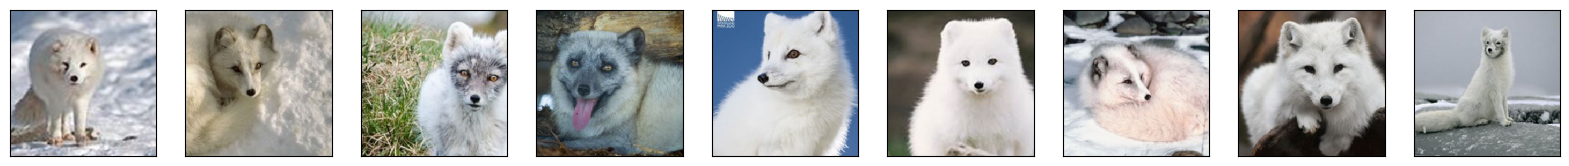

In [65]:
# Load 100 Artic fox training images and plot a subset of them
images, labels = load_images_from_path('Data/arctic-wildlife/train/arctic_fox', 0)
x_train += images
y_train += labels

show_images(images)

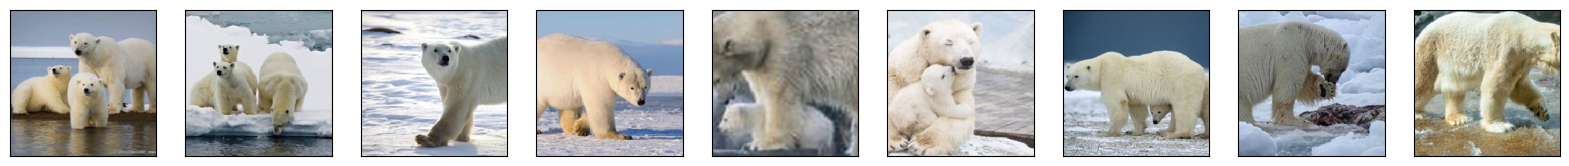

In [66]:
# Load 100 polar bear training images and plot a subset of them
images, labels = load_images_from_path('Data/arctic-wildlife/train/polar_bear', 1)
x_train += images
y_train += labels

show_images(images)

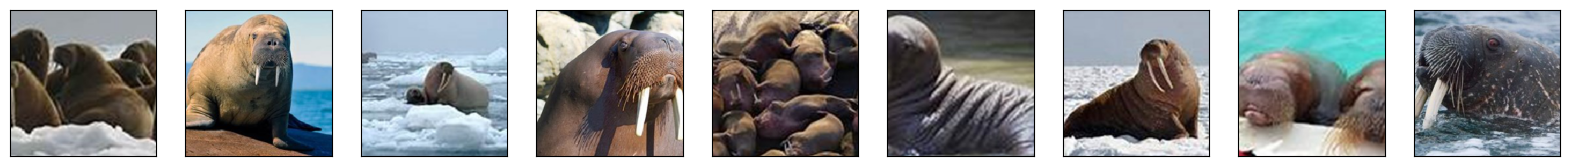

In [67]:
# Load 100 Walrus training images and plot a subset of them
images, labels = load_images_from_path('Data/arctic-wildlife/train/walrus', 2)
x_train += images
y_train += labels

show_images(images)

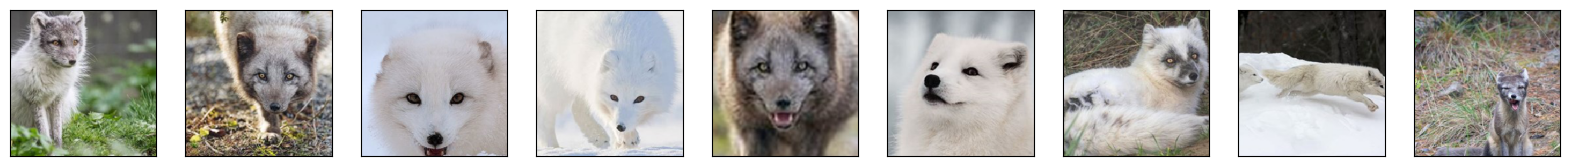

In [68]:
# Load images used to validate the CNN 
# Artic fox
images, labels = load_images_from_path('Data/arctic-wildlife/test/arctic_fox', 0)
x_test += images
y_test += labels

show_images(images)

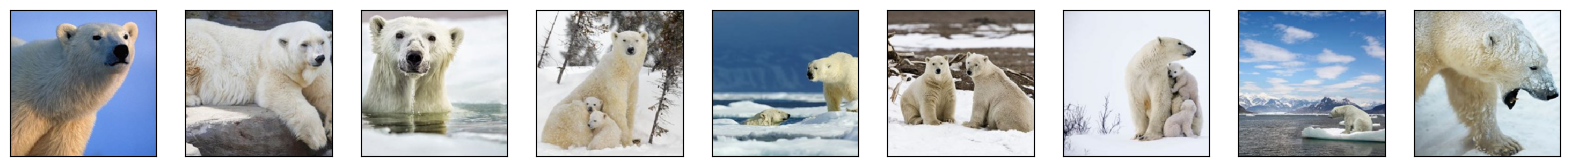

In [69]:
# Polar Bear
images, labels = load_images_from_path('Data/arctic-wildlife/test/polar_bear', 1)
x_test += images
y_test += labels

show_images(images)

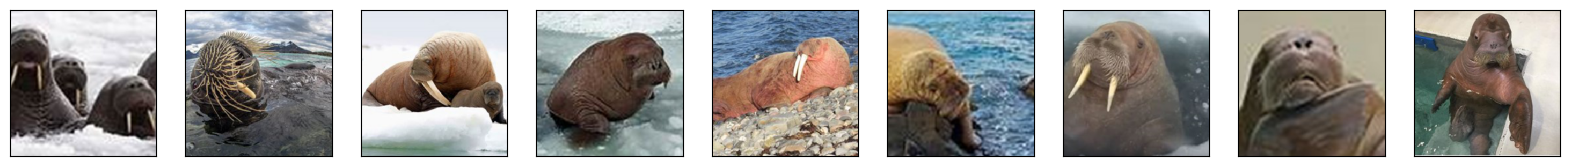

In [70]:
# Walrus
images, labels = load_images_from_path('Data/arctic-wildlife/test/walrus', 2)
x_test += images
y_test += labels

show_images(images)

In [71]:
# Normalize the training and testing images by dividing their pixel by 255
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

x_train = preprocess_input(np.array(x_train)) / 255
x_test = preprocess_input(np.array(x_test)) / 255

y_train = np.array(y_train)
y_test = np.array(y_test)

In [72]:
# next we load ResNew50V2, we load only the bottleneck layers and not the classification layers (CP & PL)

from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False)
x_train = base_model.predict(x_train)
x_test = base_model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step


In [73]:
# lets train neural network to classify features extracted from the training images
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.8700 - loss: 20.6218 - val_accuracy: 0.9500 - val_loss: 13.3094
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.9833 - loss: 2.2493 - val_accuracy: 0.9667 - val_loss: 7.0807
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.9967 - loss: 0.4208 - val_accuracy: 0.9750 - val_loss: 6.9891
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.9967 - loss: 0.3360 - val_accuracy: 0.9750 - val_loss: 7.1860
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.9967 - loss: 0.4606 - val_accuracy: 0.9500 - val_loss: 11.4590
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.9900 - loss: 1.5689 - val_accuracy: 0.9417 - val_loss: 19.7504
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.9933 - loss: 0.5402 - val_accuracy: 0.9750 - val_loss: 4.6016
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.9967 - loss: 0.4178 - val_acc

[]

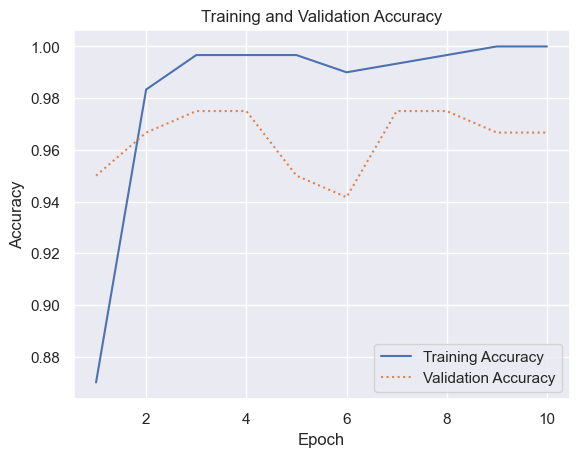

In [74]:
# lets plot the training and validation accuracy of the network

import seaborn as sns
sns.set_theme()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


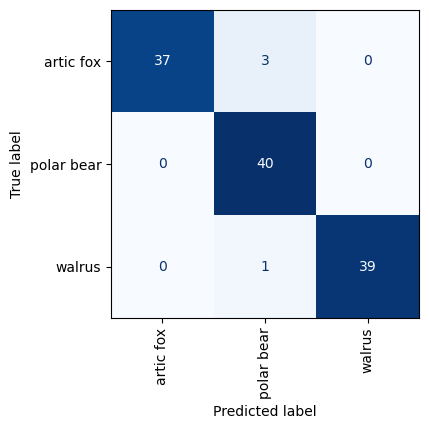

In [75]:
# lets use confusion matrix to visualize how well the network distinguishes betweek classes
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4,4))
ax.grid(False)

y_pred = model.predict(x_test)
class_labels = ['artic fox', 'polar bear', 'walrus']

cmd.from_predictions(y_test, y_pred.argmax(axis=1), display_labels=class_labels, colorbar=False, cmap='Blues', xticks_rotation='vertical', ax=ax)

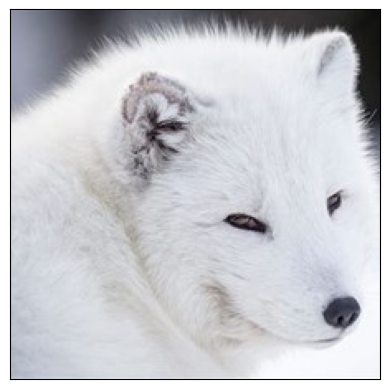

In [76]:
# Lets load the Artic fox image sample from the images the model was not trained on
x = image.load_img('Data/arctic-wildlife/samples/arctic_fox/arctic_fox_140.jpeg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [78]:
# lets preprocess and run thru the ResNet feature extraction layer and then run the output throught the newly trained classification layers
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

ValueError: Unsupported image shape: (1, 224, 224, 3)

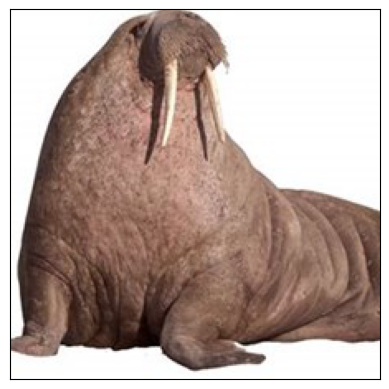

In [80]:
# lets load walrus image
x = image.load_img('Data/arctic-wildlife/samples/walrus/walrus_143.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [81]:
# lets preprocess and run thru the ResNet feature extraction layer and then run the output throught the newly trained classification layers
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


2025-11-18 07:55:21.328629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] mismatch In[1] shape: 100352 vs. 131072: [1,100352] [131072,1024] 0 0
	 [[{{node sequential_4_1/dense_8_1/Relu}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/dense_8_1/Relu defined at (most recent call last):
  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 508, in process_one

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/cn/9g5qj0_11ygbqv6gb8bc85b40000gn/T/ipykernel_94803/2871367094.py", line 7, in <module>

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 566, in predict

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 260, in one_step_on_data_distributed

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 250, in one_step_on_data

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 105, in predict_step

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/models/sequential.py", line 220, in call

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/models/functional.py", line 183, in call

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/ops/function.py", line 206, in _run_through_graph

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/models/functional.py", line 644, in call

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 155, in call

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/activations/activations.py", line 47, in relu

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/activations/activations.py", line 101, in static_call

  File "/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 15, in relu

In[0] mismatch In[1] shape: 100352 vs. 131072: [1,100352] [131072,1024] 0 0
	 [[{{node sequential_4_1/dense_8_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_71215]